In [1]:
import os
import pandas as pd

# Bibliotecas para visualização dos dados
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
from myutil import read_simulation, read_simulation_dataset

In [3]:
%%time

SIMULATION_FOLDER = "20200422_hybridi"
filetemplate = "trial_{0}_simulation.csv"

raw_data = read_simulation(SIMULATION_FOLDER, filetemplate)

raw_data.head()

Wall time: 5.2 s


,nro_trial,instance_problem,nro_nodes,nro_edges,nro_terminals,tx_crossover,tx_mutation,global_optimum,best_cost,best_fitness,population_size,max_generation,iterations,run_time,max_last_improvement,why_stopped
0,1,B13,100,125,17,0.85,0.4,165,221,386,100,10000,703,128.383231,501,stagnation
1,1,B13,100,125,17,0.85,0.4,165,197,197,100,10000,704,130.959962,501,stagnation
2,1,B13,100,125,17,0.85,0.4,165,224,390,100,10000,1103,223.330025,501,stagnation
3,1,B13,100,125,17,0.85,0.4,165,198,313,100,10000,702,140.273656,501,stagnation
4,1,B13,100,125,17,0.85,0.4,165,224,292,100,10000,705,134.775771,501,stagnation


## Identificando as razões de parada

Em um primeiro momento a parada dos indivíduos se deu por estagnação e por atingir o máximo global.
E observando a frequência que a parada por atingir o máximo global ocorre apenas em 2 execuções.

Entretanto uma olhada próxima sobre as razões de parada, não existe um único registro onde o máximo global é igual ao melhor resultado encontrado.

Podemos ver ainda que existe 44 registros onde o ótimo local registrado é menor que o ótimo global informado. Isso pode ser um indicador de que algo está errado com o operador.

O mesmo parece não ocorrer com os experimentos utilizando somente o Operador ''SimpliestCrossover''

In [4]:
raw_data["why_stopped"].unique()

array(['stagnation', 'global_optimum_reached'], dtype=object)

In [5]:
raw_data["why_stopped"].value_counts()

stagnation                178
global_optimum_reached      2
Name: why_stopped, dtype: int64

In [6]:
raw_data[raw_data["why_stopped"] == "global_optimum_reached"]

,nro_trial,instance_problem,nro_nodes,nro_edges,nro_terminals,tx_crossover,tx_mutation,global_optimum,best_cost,best_fitness,population_size,max_generation,iterations,run_time,max_last_improvement,why_stopped
53,1,B14,100,125,25,0.85,0.4,235,224,432,100,10000,603,141.524916,0,global_optimum_reached
77,1,B15,100,125,50,0.85,0.4,318,308,27,100,10000,604,161.062589,0,global_optimum_reached


In [7]:
df = raw_data[raw_data["global_optimum"] > raw_data["best_cost"]]

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44 entries, 35 to 179
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   nro_trial             44 non-null     int64  
 1   instance_problem      44 non-null     object 
 2   nro_nodes             44 non-null     int64  
 3   nro_edges             44 non-null     int64  
 4   nro_terminals         44 non-null     int64  
 5   tx_crossover          44 non-null     float64
 6   tx_mutation           44 non-null     float64
 7   global_optimum        44 non-null     int64  
 8   best_cost             44 non-null     int64  
 9   best_fitness          44 non-null     int64  
 10  population_size       44 non-null     int64  
 11  max_generation        44 non-null     int64  
 12  iterations            44 non-null     int64  
 13  run_time              44 non-null     float64
 14  max_last_improvement  44 non-null     int64  
 15  why_stopped           4

In [9]:
pd.value_counts(df['instance_problem'])

B15    21
B18    20
B14     3
Name: instance_problem, dtype: int64

In [10]:
categorical_order = ["B{0}".format(i) for i in range(13,19)]

In [11]:
selected_columns = ["instance_problem", "nro_nodes", "nro_edges", "nro_terminals", "global_optimum"]
frame = raw_data[selected_columns].drop_duplicates()  \
                                    .set_index("instance_problem") \
                                    .reindex(categorical_order, axis=0)

In [12]:
basic_stats = ['mean','std' ,'min', 'max']
grouped = raw_data.groupby("instance_problem")

In [13]:
frame.columns = pd.MultiIndex.from_tuples([("graph", col) for col in frame.columns])

frame2 = frame.join(
        grouped[["best_cost", "iterations", "run_time"]] \
        .agg(['mean', 'std']) \
        .reindex(categorical_order)
    ).round(2)

In [14]:
frame2

graph                                        best_cost  \
                 nro_nodes nro_edges nro_terminals global_optimum      mean   
instance_problem                                                              
B13                    100       125            17            165    218.53   
B14                    100       125            25            235    260.03   
B15                    100       125            50            318    310.47   
B16                    100       200            17            127    165.30   
B17                    100       200            25            131    151.73   
B18                    100       200            50            218    214.90   

                        iterations         run_time          
                    std       mean     std     mean     std  
instance_problem                                             
B13               16.66     967.37  370.23   182.82   67.43  
B14               18.85     855.83  262.72   186.61   61.54  
B15               12.78     927.43  456.63   254.50  127.67  
B16               11.37    1040.80  377.45   216.27   75.01  
B17                7.95     910.40  349.60   211.79   80.34  
B18                4.60    1043.90  371.36   293.64  118.53

In [16]:
# frame2.to_clipboard()

# frame2.to_csv(os.path.join("..", "outputdata", "processed", "ga_hybridi.csv"))

In [17]:
frame2[["graph", "best_cost"]]

graph                                        best_cost  \
                 nro_nodes nro_edges nro_terminals global_optimum      mean   
instance_problem                                                              
B13                    100       125            17            165    218.53   
B14                    100       125            25            235    260.03   
B15                    100       125            50            318    310.47   
B16                    100       200            17            127    165.30   
B17                    100       200            25            131    151.73   
B18                    100       200            50            218    214.90   

                         
                    std  
instance_problem         
B13               16.66  
B14               18.85  
B15               12.78  
B16               11.37  
B17                7.95  
B18                4.60

Text(0.5, 0, 'Melhor custo')

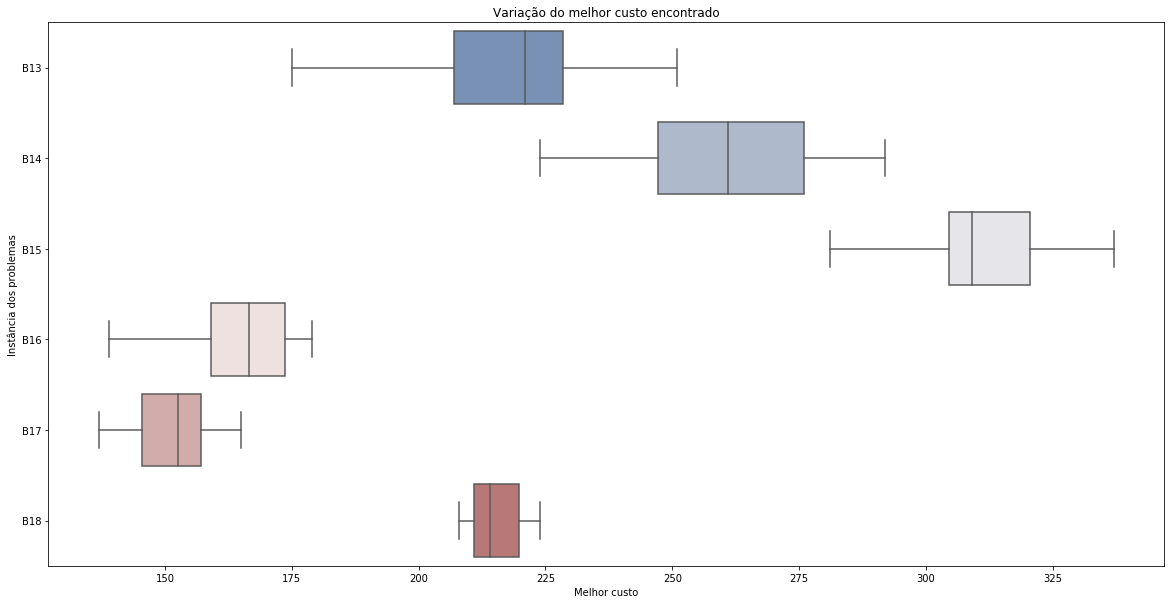

In [18]:
fig = plt.figure(figsize=(20, 10))


sns.boxplot(x="best_cost", 
            y="instance_problem",            
            data=raw_data,
            palette="vlag",
           )

plt.title(label=f'Variação do melhor custo encontrado')
plt.ylabel("Instância dos problemas")
plt.xlabel("Melhor custo")

In [19]:
frame2[["graph", "iterations"]]

graph                                        iterations  \
                 nro_nodes nro_edges nro_terminals global_optimum       mean   
instance_problem                                                               
B13                    100       125            17            165     967.37   
B14                    100       125            25            235     855.83   
B15                    100       125            50            318     927.43   
B16                    100       200            17            127    1040.80   
B17                    100       200            25            131     910.40   
B18                    100       200            50            218    1043.90   

                          
                     std  
instance_problem          
B13               370.23  
B14               262.72  
B15               456.63  
B16               377.45  
B17               349.60  
B18               371.36

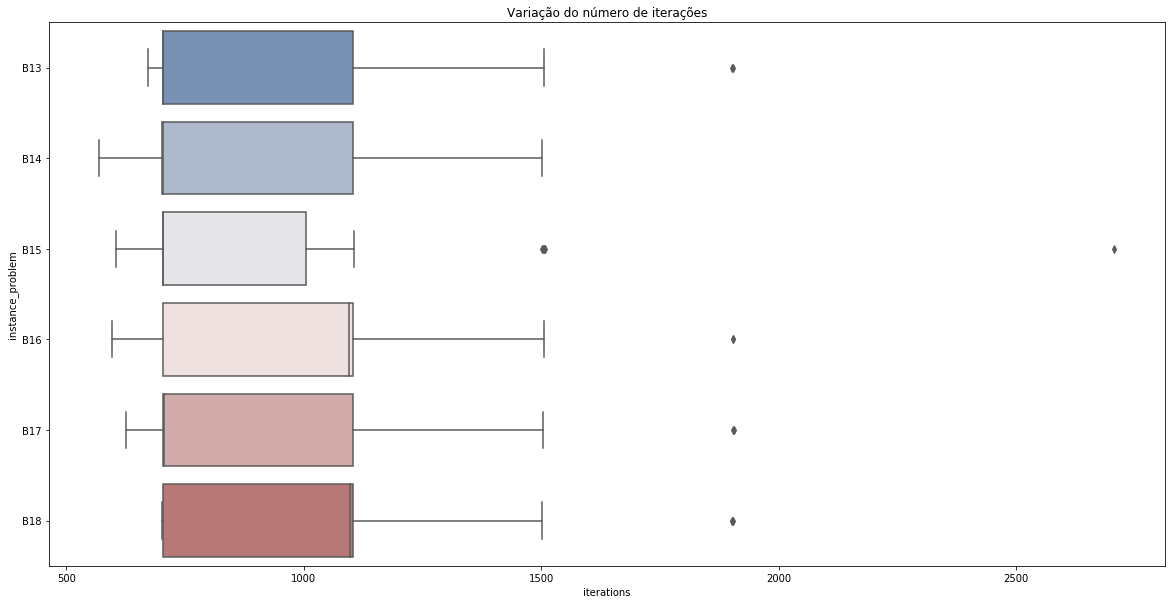

In [20]:
fig = plt.figure(figsize=(20, 10))
plt.title(label=f'Variação do número de iterações')

sns.boxplot(x="iterations", 
            y="instance_problem",            
            data=raw_data,
            palette="vlag",
           )

In [21]:
frame2[["graph", "run_time"]]

graph                                        run_time  \
                 nro_nodes nro_edges nro_terminals global_optimum     mean   
instance_problem                                                             
B13                    100       125            17            165   182.82   
B14                    100       125            25            235   186.61   
B15                    100       125            50            318   254.50   
B16                    100       200            17            127   216.27   
B17                    100       200            25            131   211.79   
B18                    100       200            50            218   293.64   

                          
                     std  
instance_problem          
B13                67.43  
B14                61.54  
B15               127.67  
B16                75.01  
B17                80.34  
B18               118.53

In [22]:
%%time

DATASET = "B13"
file = "trial_{0}_best_fitness.csv"
dfbest_fit = read_simulation_dataset(DATASET, SIMULATION_FOLDER, file)

Wall time: 793 ms


In [23]:
dfbest_fit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 979 entries, 0 to 23
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   iteration  979 non-null    int64 
 1   cost       979 non-null    int64 
 2   fitness    979 non-null    int64 
 3   trial      979 non-null    object
dtypes: int64(3), object(1)
memory usage: 38.2+ KB


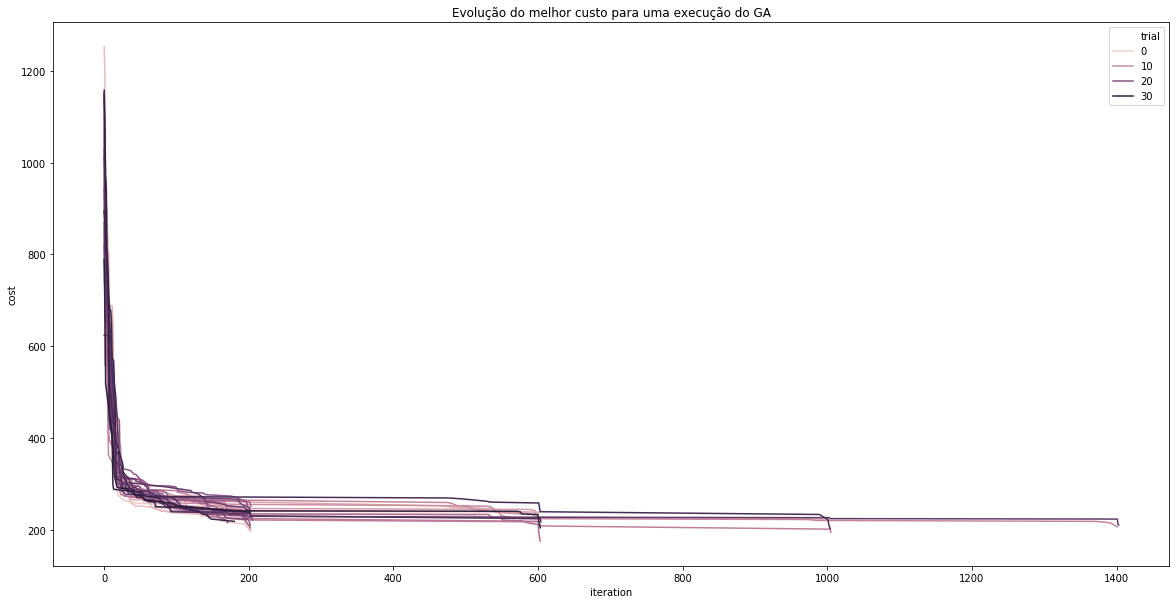

In [24]:
fig = plt.figure(figsize=(20, 10))
plt.title(label=f'Evolução do melhor custo para uma execução do GA')

g = sns.lineplot(x="iteration",
                y="cost",
                hue="trial",
                data=dfbest_fit)

Text(0.5, 0, 'Geração')

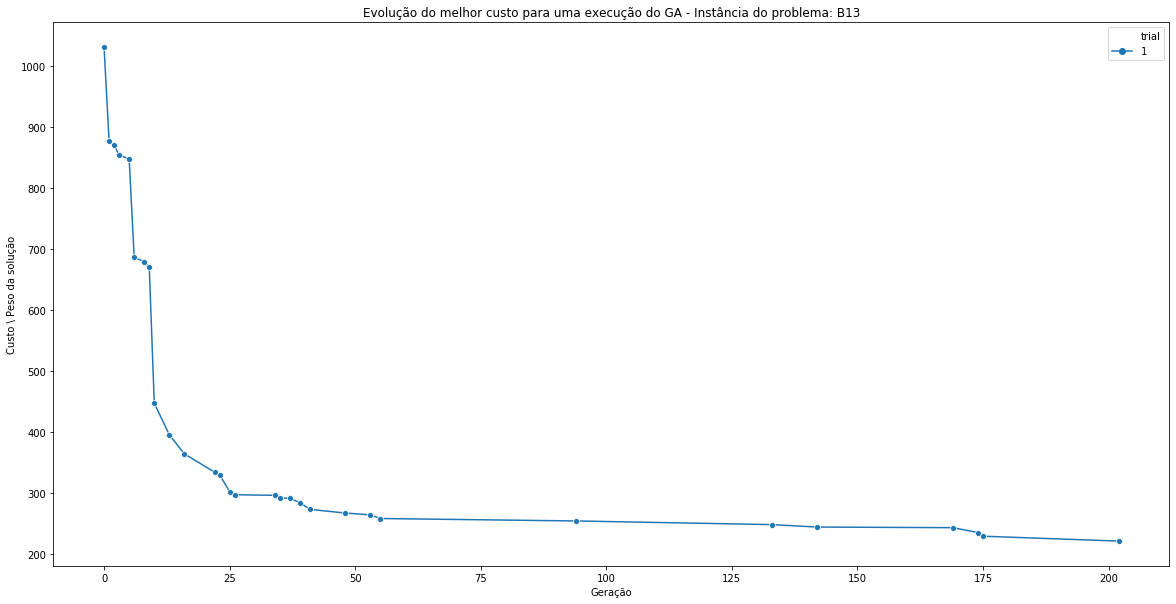

In [25]:
fig = plt.figure(figsize=(20, 10))

g = sns.lineplot(x="iteration",
                y="cost",
                hue="trial",
                style="trial",
                markers=True,
                data=dfbest_fit[dfbest_fit["trial"] == '1'])

plt.title(label=f'Evolução do melhor custo para uma execução do GA - Instância do problema: {DATASET}')
plt.ylabel("Custo \ Peso da solução")
plt.xlabel("Geração")

In [29]:
# df = dfbest_fit[dfbest_fit["trial"] == '1']

# df.to_csv(os.path.join("..", "outputdata", "processed", "gahybridi_bestfit_trial1.csv"))

In [26]:
%%time 
file = "trial_{0}_evaluation.csv"

df_evaluation = read_simulation_dataset(DATASET, SIMULATION_FOLDER, file)

Wall time: 1.64 s


Wall time: 16.9 s


Text(0.5, 0, 'Geração')

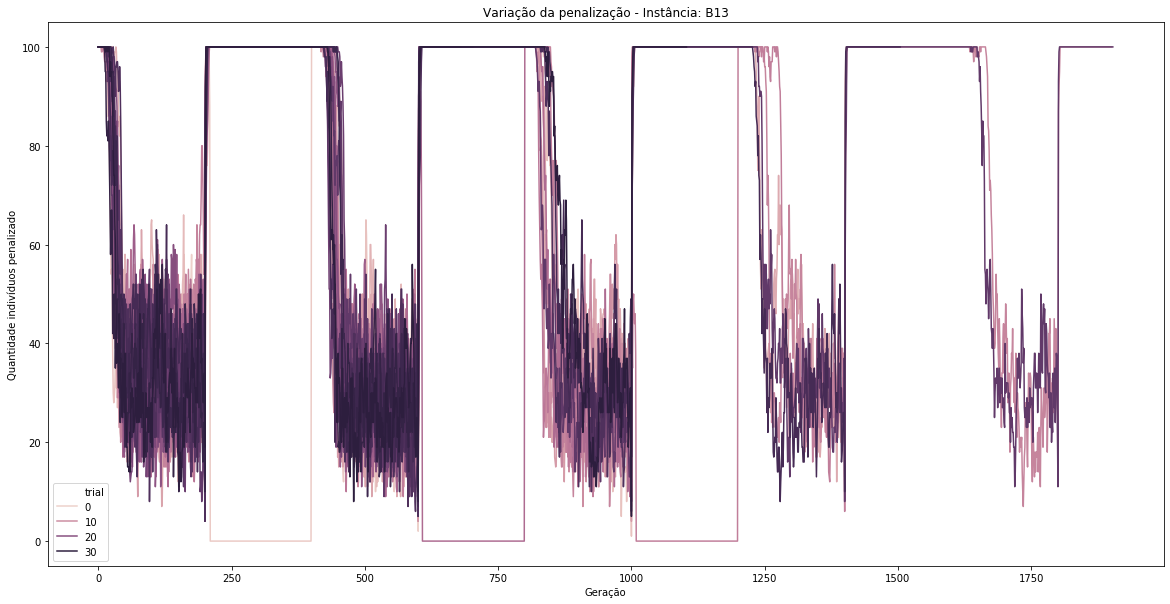

In [27]:
%%time

fig = plt.figure(figsize=(20, 10))
plt.title(label=f'Variação da penalização - Instância: {DATASET}')

g = sns.lineplot(x="iteration",
                y="penalization",
                hue='trial',
                data=df_evaluation)

plt.ylabel("Quantidade indivíduos penalizado")
plt.xlabel("Geração")